# Creating a restaurant rating prediction model

### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import datetime
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from collections import Counter
import re
from sklearn.preprocessing import StandardScaler

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# Fixing RANDOM_SEED so that the experiments are reproducible
RANDOM_SEED = 42

In [3]:
# Fixing the version of the packages so that the experiments are reproducible
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# For correct feature processing, we combine the training and testing datasets into one dataset
df_train['sample'] = 1 # training dataset
df_test['sample'] = 0 # testing dataset
df_test['Rating'] = 0 # in the test, we don't have a Rating value, we have to predict it, so for now we just fill it with zeros

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

More about features:

* City: City 
* Cuisine Style: Cuisine Style
* Ranking: The rank of the restaurant is relative to other restaurants in this city
* Price Range: Restaurant prices in 3 categories
* Number of Reviews: Number of reviews
* Reviews: 2 most recent reviews and the dates of those reviews
* URL_TA: page of the restaurant on 'www.tripadvisor.com' 
* ID_TA: ID restaurant on TripAdvisor
* Rating: The restaurant's rating

# Cleaning and Prepping Data

## 1. Processing NAN 
There may be different reasons for the presence of omissions, the omissions must either be filled in or excluded from the set completely. But with omissions, you need to be careful, since even the lack of information can be an important sign!
Therefore, before processing NAN, it is better to take out information about the presence of a pass as a separate feature 

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Fill in the empty values

Feature Cuisine Style

In [13]:
data['Cuisine Style']

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: Cuisine Style, Length: 50000, dtype: object

In [14]:
data['Cuisine Style'].value_counts()

['Italian']                                                                                                                         1332
['French']                                                                                                                          1019
['Spanish']                                                                                                                          860
['French', 'European']                                                                                                               503
['Cafe']                                                                                                                             500
                                                                                                                                    ... 
['Central European', 'European', 'Hungarian']                                                                                          1
['Cafe', 'British', 'Healthy', 'Gluten Fr

Saveing the null values, filling in the empty ones

In [15]:
data['NAN_Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('float64')
data['Cuisine Style'].fillna("['Other']", inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
NAN_Cuisine Style    50000 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 4.6+ MB


Feature Price Range

In [17]:
data['NAN_Price Range'] = pd.isna(data['Price Range']).astype('float64')

data['Price Range'] = data['Price Range'].fillna(0)


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Price Range          50000 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
NAN_Cuisine Style    50000 non-null float64
NAN_Price Range      50000 non-null float64
dtypes: float64(5), int64(1), object(7)
memory usage: 5.0+ MB


Feature Number of Reviews

In [19]:
data['NAN_Number_of_Reviews_is'] = pd.isna(data['Number of Reviews']).astype('float64')

In [20]:
# Filling in the empty ones with zeros
data['Number of Reviews'].fillna(0, inplace=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
Restaurant_id               50000 non-null object
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     49998 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
dtypes: float64(6), int64(1), object(7)
memory usage: 5.3+ MB


In [22]:
data['NAN_Reviews'] = pd.isna(data['Reviews']).astype('float64')
data['Reviews'].fillna("[[], []]", inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
Restaurant_id               50000 non-null object
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
dtypes: float64(7), int64(1), object(7)
memory usage: 5.7+ MB


### 2. Feature processing

Restaurant_id

In [24]:
data.Restaurant_id.value_counts()

id_227      19
id_633      19
id_436      19
id_871      19
id_321      18
            ..
id_12361     1
id_13927     1
id_14539     1
id_7401      1
id_5669      1
Name: Restaurant_id, Length: 13094, dtype: int64

This feature may depend on the order in which the restaurant is added, and this may affect the rating. Leave it by converting

In [25]:
def change_id(x):
    if 'id_' in str(x):
        return str(x).replace('id_', '')
    else: return x
data.Restaurant_id = data.Restaurant_id.apply(change_id)
data.Restaurant_id = pd.to_numeric(data.Restaurant_id)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
dtypes: float64(7), int64(2), object(6)
memory usage: 5.7+ MB


Feature 'City'

In [27]:
data.City.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [28]:
data['City_origin'] = data['City']

In [29]:
#data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 6.1+ MB


Feature 'Cuisine Style'

In [31]:
type(data['Cuisine Style'].iloc[0])

str

In [32]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: re.findall('\w+\s*\w+\s*\w+', str(x)))

In [33]:
type(data['Cuisine Style'].iloc[15])

list

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 6.1+ MB


Feature 'Ranking'

In [35]:
data.Ranking.value_counts()

93.0       22
72.0       21
491.0      21
842.0      21
1013.0     20
           ..
8027.0      1
10415.0     1
14621.0     1
11766.0     1
10585.0     1
Name: Ranking, Length: 12975, dtype: int64

Leaving as it is

In [36]:
data['Price Range'].value_counts()

$$ - $$$    23041
0           17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [37]:
#Converting

price_dict = {"0": 0, "$": 1, "$$ - $$$": 2, "$$$$": 3}

data['Price Range'] = data['Price Range'].replace(to_replace=price_dict)
data['Price Range'].value_counts()

2    23041
0    17361
1     7816
3     1782
Name: Price Range, dtype: int64

Feature 'Number of Reviews'

In [38]:
data['Number of Reviews'].value_counts()

0.0       3200
2.0       2403
3.0       2042
4.0       1707
5.0       1471
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1574, dtype: int64

****Reviews

In [39]:
type(data.Reviews.iloc[0])

str

In [40]:
data['Reviews'].value_counts()

[[], []]                                                                                                                              8114
[['Great food, service and atmosphere', 'Decor and food'], ['11/06/2017', '10/22/2017']]                                                 2
[['Delicious soup', 'My weekly treat'], ['03/19/2017', '07/30/2017']]                                                                    2
[['Good Paella', 'Good enough. Nothing more'], ['09/20/2017', '05/29/2017']]                                                             2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                                                         2
                                                                                                                                      ... 
[['Excellent restaurant both for lunch and di...', 'not sure if its French - but still very go...'], ['03/28/2012', '06/11/2011']]       1
[['Pleasant craft beer pub'

In [41]:
def fill_na_reviews(x):
    if x == '[[], []]':
        return None
    else:
        return x
data['Reviews'] = data['Reviews'].fillna(fill_na_reviews)

In [42]:
data['Review_date'] = data['Reviews'].str.findall('\d+/\d+/\d+')


In [43]:
data['Review_date']

0                              []
1        [12/05/2017, 10/29/2017]
2        [12/28/2017, 12/06/2017]
3        [12/06/2017, 11/22/2017]
4        [02/08/2018, 01/24/2018]
                   ...           
49995    [12/16/2017, 11/12/2017]
49996    [12/21/2017, 12/12/2017]
49997    [11/03/2016, 04/12/2008]
49998    [07/11/2017, 06/18/2017]
49999    [01/31/2016, 07/04/2012]
Name: Review_date, Length: 50000, dtype: object

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
dtypes: float64(7), int64(3), object(

In [45]:
data.URL_TA

0        /Restaurant_Review-g187147-d10746918-Reviews-L...
1        /Restaurant_Review-g189934-d6674944-Reviews-Ra...
2        /Restaurant_Review-g186525-d13129638-Reviews-B...
3        /Restaurant_Review-g186338-d680417-Reviews-Qui...
4        /Restaurant_Review-g274924-d1112354-Reviews-Ma...
                               ...                        
49995    /Restaurant_Review-g187849-d2104414-Reviews-Ro...
49996    /Restaurant_Review-g187147-d1800036-Reviews-La...
49997    /Restaurant_Review-g189852-d947615-Reviews-Sus...
49998    /Restaurant_Review-g274856-d1100838-Reviews-Ho...
49999    /Restaurant_Review-g187849-d1109020-Reviews-Ta...
Name: URL_TA, Length: 50000, dtype: object

In [46]:
data.drop(['URL_TA'], axis=1, inplace=True)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
dtypes: float64(7), int64(3), object(6)
memory usage: 6.1+ MB


In [48]:
data.ID_TA

0        d10746918
1         d6674944
2        d13129638
3          d680417
4         d1112354
           ...    
49995     d2104414
49996     d1800036
49997      d947615
49998     d1100838
49999     d1109020
Name: ID_TA, Length: 50000, dtype: object

While we do not know whether it will be necessary, we convert feature to a numeric feature

In [49]:
def change_id_TA(x):
    if 'd' in str(x):
        return str(x).replace('d', '')
    else: return x
data.ID_TA = data.ID_TA.apply(change_id_TA)
data.ID_TA = pd.to_numeric(data.ID_TA)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
dtypes: float64(7), int64(4), object(5)
memory usage: 6.1+ MB


# Feature Engeneering

In [51]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'ID_TA', 'sample', 'Rating',
       'NAN_Cuisine Style', 'NAN_Price Range', 'NAN_Number_of_Reviews_is',
       'NAN_Reviews', 'City_origin', 'Review_date'],
      dtype='object')

In [52]:
cuisines = set()

for i in data['Cuisine Style']:
    for j in i:
        cuisines.add(j)

In [53]:
cuisines

{'Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Creole',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mex

In [54]:
food = {}  # creating an empty dictionary to store information about ingredients
for item in cuisines:  # sorting through the list of ingredients
    # add the key corresponding to the next ingredient to the dictionary
    food[item] = 0

for i in data['Cuisine Style']:   # going through the list of recipes
    for j in i:   # and through the list of ingredients in recipes
        food[j] += 1   # increase the value of the desired key in the dictionary by 1

In [55]:
food

{'Southwestern': 24,
 'Brew Pub': 299,
 'Arabic': 58,
 'Taiwanese': 30,
 'Filipino': 17,
 'Pub': 3058,
 'Vietnamese': 622,
 'Armenian': 17,
 'British': 1992,
 'Korean': 206,
 'Afghani': 27,
 'Irish': 352,
 'Peruvian': 130,
 'Greek': 768,
 'Chilean': 16,
 'Scandinavian': 449,
 'Halal': 773,
 'Venezuelan': 51,
 'Danish': 225,
 'Jamaican': 36,
 'Romanian': 13,
 'Albanian': 8,
 'Tibetan': 29,
 'Barbecue': 710,
 'Fujian': 2,
 'Australian': 36,
 'Eastern European': 629,
 'Middle Eastern': 980,
 'Pakistani': 140,
 'Sri Lankan': 30,
 'Mongolian': 20,
 'Latin': 373,
 'Norwegian': 96,
 'Xinjiang': 1,
 'Canadian': 7,
 'Minority Chinese': 12,
 'Moroccan': 173,
 'German': 820,
 'Austrian': 462,
 'Diner': 375,
 'Healthy': 758,
 'Asian': 3786,
 'Welsh': 3,
 'Grill': 617,
 'French': 3970,
 'Argentinean': 214,
 'Bangladeshi': 100,
 'Georgian': 18,
 'Caucasian': 4,
 'Gluten Free Options': 5185,
 'Salvadoran': 1,
 'Cajun': 27,
 'American': 1642,
 'Central European': 1727,
 'Yunnan': 2,
 'Vegetarian Frien

In [56]:
pop_cuisine = []
for key, value in food.items():
    if value > 3000:
        pop_cuisine.append(key)
pop_cuisine

['Pub',
 'Asian',
 'French',
 'Gluten Free Options',
 'Vegetarian Friendly',
 'Pizza',
 'Spanish',
 'Mediterranean',
 'European',
 'Other',
 'Italian',
 'Vegan Options',
 'Bar']

In [57]:
type(data['Cuisine Style'].iloc[0])

list

In [58]:
def popular_cuisine(x):
    for element in pop_cuisine:
        if element in x:
            return 1
        else:
            continue
data['Popular_cuisine'] = data['Cuisine Style'].apply(popular_cuisine)

In [59]:
data['Popular_cuisine'].value_counts(dropna = False)

1.0    43646
NaN     6354
Name: Popular_cuisine, dtype: int64

In [60]:
data['Popular_cuisine'].fillna(0, inplace = True)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
dtypes: float64(8), int64(4), object(

In [62]:
data['Count_cuisines'] = data['Cuisine Style'].apply(lambda x: len(x))

In [63]:
data['Count_cuisines'].value_counts(dropna=False)

1     20738
2      7797
3      6635
4      5948
5      4486
6      2611
7      1294
8       365
9        93
10       26
11        4
21        1
15        1
13        1
Name: Count_cuisines, dtype: int64

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

****Reviews

In [65]:
data['Review_date'] = data['Reviews'].str.findall('\d+/\d+/\d+')
data['len_of_reviews'] = data['Review_date'].apply(lambda x: x if x == None else len(x))
data['len_of_reviews'].value_counts(dropna = False)

2    36202
0     8114
1     5680
3        4
Name: len_of_reviews, dtype: int64

In [66]:
data['len_of_reviews'].fillna(2, inplace = True)

In [67]:
def days_to_now(row):
    if row['Review_date'] == None:
        return None
    return datetime.datetime.now() - pd.to_datetime(row['Review_date']).max()

def days_between_reviews(row):
    if row['Review_date'] == None:
        return None
    return pd.to_datetime(row['Review_date']).max() - pd.to_datetime(row['Review_date']).min()

data['Days_to_now'] = data.apply(days_to_now, axis = 1).dt.days
data['Days_between_reviews'] = data[data['len_of_reviews']==2].apply(days_between_reviews, axis = 1).dt.days


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

In [69]:
data['Days_between_reviews'].value_counts(dropna = False)

NaN       13798
1.0         829
0.0         631
2.0         629
3.0         606
          ...  
1924.0        1
1554.0        1
1335.0        1
1576.0        1
1543.0        1
Name: Days_between_reviews, Length: 1311, dtype: int64

In [70]:
data['Days_to_now'] = data['Days_to_now'].fillna(data['Days_to_now'].median())
data['Days_between_reviews'] = data['Days_between_reviews'].fillna(data['Days_between_reviews'].median())


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

Feature 'City Origin'

In [72]:
data['City_origin'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City_origin, dtype: int64

In [73]:
Сity_population_dict = {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
data['Сity_population'] = data.apply(lambda row: Сity_population_dict[row['City_origin']], axis = 1)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

In [75]:
data['Сount_of_rest'] = data['City_origin'].map(data.groupby('City_origin')['Ranking'].max().to_dict())

In [76]:
data['Сount_of_rest'].value_counts()

16444.0    7193
13986.0    6108
8809.0     3813
7796.0     3395
6372.0     2705
6275.0     2694
5948.0     2589
4188.0     1816
3717.0     1647
3444.0     1443
3254.0     1372
3006.0     1314
2737.0     1186
2763.0     1145
2666.0     1126
2464.0     1033
2440.0     1021
2154.0      925
1960.0      836
1964.0      819
1787.0      776
1766.0      745
1601.0      685
1484.0      642
1413.0      590
1244.0      554
1137.0      488
1141.0      475
889.0       380
621.0       263
468.0       222
Name: Сount_of_rest, dtype: int64

In [77]:
data['Rest_on_person'] = data['Сity_population']/data['Сount_of_rest']

In [78]:
data['Rest_on_person']

0        0.157729
1        0.563541
2        0.290487
3        0.541717
4        0.479190
           ...   
49995    0.217689
49996    0.157729
49997    0.390016
49998    0.818942
49999    0.217689
Name: Rest_on_person, Length: 50000, dtype: float64

In [79]:
data['Ranking_on_city'] = data['Ranking'] / data['Сount_of_rest']

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

# EDA - Exploratory data analysis

In [81]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'ID_TA', 'sample', 'Rating',
       'NAN_Cuisine Style', 'NAN_Price Range', 'NAN_Number_of_Reviews_is',
       'NAN_Reviews', 'City_origin', 'Review_date', 'Popular_cuisine',
       'Count_cuisines', 'len_of_reviews', 'Days_to_now',
       'Days_between_reviews', 'Сity_population', 'Сount_of_rest',
       'Rest_on_person', 'Ranking_on_city'],
      dtype='object')

### Let's look at the distribution of the feature

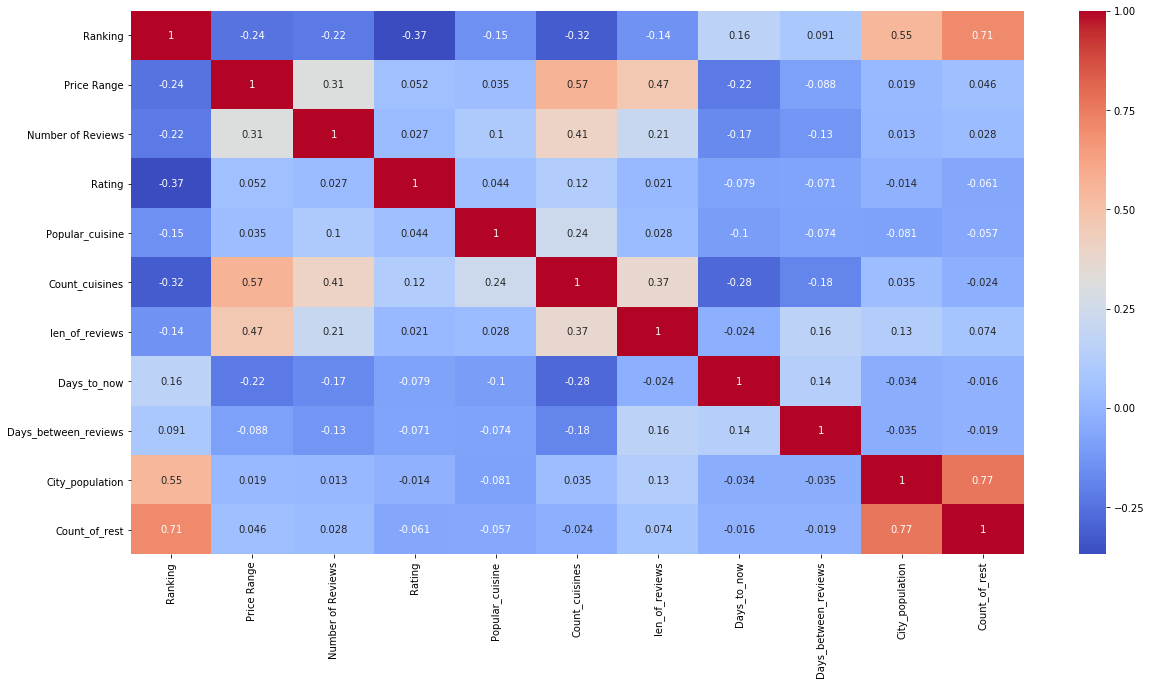

In [82]:
correlation = data[data['sample'] == 1][['Ranking', 'Price Range','Number of Reviews', 'Rating','Popular_cuisine', 'Count_cuisines', 'len_of_reviews', 'Days_to_now', 'Days_between_reviews', 'Сity_population', 'Сount_of_rest']].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

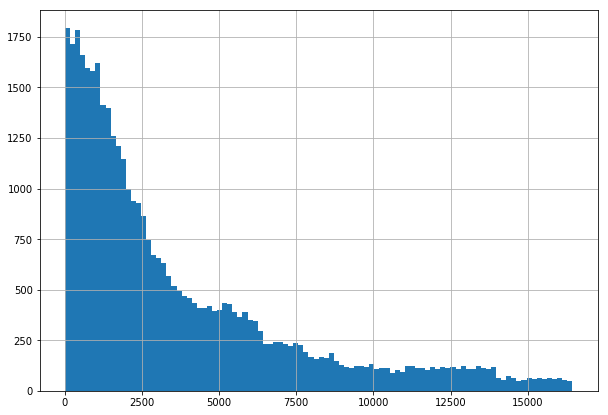

In [83]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

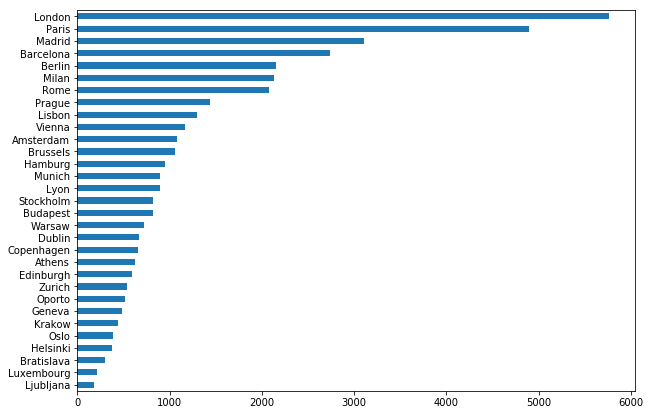

In [84]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Let's see how the distribution changes in a big city

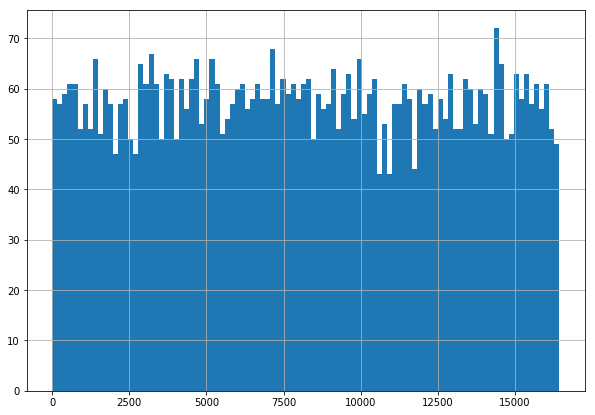

In [85]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

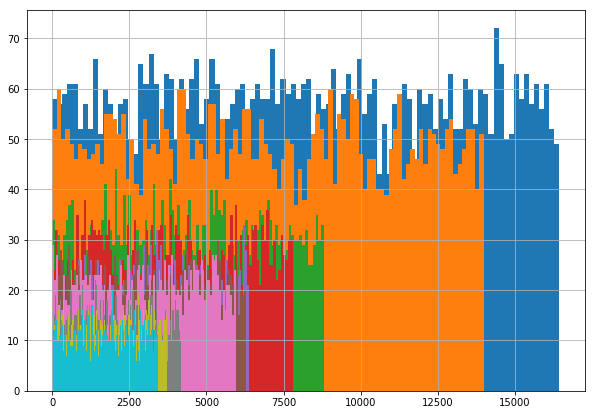

In [86]:
# Let's see on top-10 cities
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Let's look at the distribution of the target variable

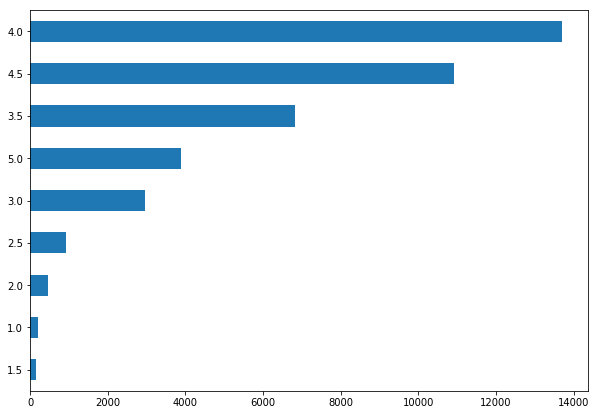

In [87]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Let's look at the distribution of the target variable relative to the attribute

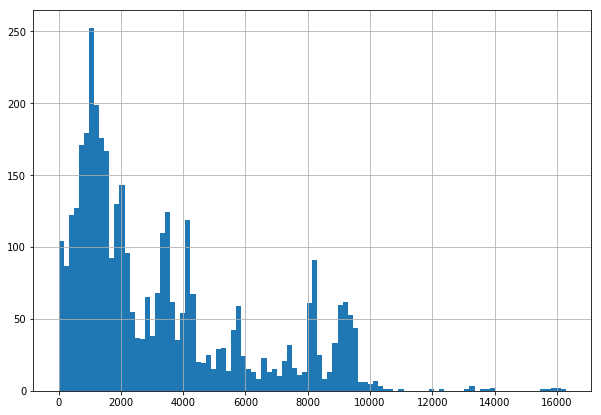

In [88]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

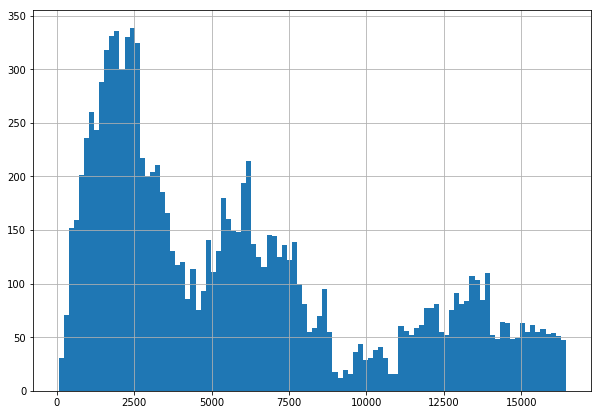

In [89]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

In [90]:
mn = data.groupby('City_origin')['Ranking'].mean()
st = data.groupby('City_origin')['Ranking'].std()
data['Std_Ranking'] = (data['Ranking'] - data['City_origin'].map(mn))/data['City_origin'].map(st)

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

# Data Preprocessing


In [92]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'ID_TA', 'sample', 'Rating',
       'NAN_Cuisine Style', 'NAN_Price Range', 'NAN_Number_of_Reviews_is',
       'NAN_Reviews', 'City_origin', 'Review_date', 'Popular_cuisine',
       'Count_cuisines', 'len_of_reviews', 'Days_to_now',
       'Days_between_reviews', 'Сity_population', 'Сount_of_rest',
       'Rest_on_person', 'Ranking_on_city', 'Std_Ranking'],
      dtype='object')

In [93]:
data.drop(['Restaurant_id','NAN_Cuisine Style', 'NAN_Price Range', 'Cuisine Style', 'Reviews', 'ID_TA', 'NAN_Cuisine_Style', 'len_of_reviews','NAN_Price_Range', 'NAN_Number_of_Reviews_is','NAN_Reviews', 'City_origin', 'City', 'Review_date'], axis=1, inplace=True, errors='ignore')

In [94]:
data.columns

Index(['Ranking', 'Price Range', 'Number of Reviews', 'sample', 'Rating',
       'Popular_cuisine', 'Count_cuisines', 'Days_to_now',
       'Days_between_reviews', 'Сity_population', 'Сount_of_rest',
       'Rest_on_person', 'Ranking_on_city', 'Std_Ranking'],
      dtype='object')

In [95]:
# Now select the test part
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values # our target
X = train_data.drop(['Rating'], axis=1)

Before sending our data for training, we will divide the data into another test and training for validation.
This will help us check how well our model works before submitting a submission to kaggle.

In [96]:
# Let's use a special function train_test_split
# we will allocate 20% of the data for validation (test_size parameter)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [97]:
# Let's check
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 13), (40000, 13), (40000, 12), (32000, 12), (8000, 12))

# Model 
ML

In [98]:
# Importing the necessary libraries:
from sklearn.ensemble import RandomForestRegressor # A tool for creating and training a model
from sklearn import metrics # Tools for assessing the accuracy of the model

In [99]:
# Creating model
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [100]:
# Training the model on a test dataset
model.fit(X_train, y_train)

# We use a trained model to predict the rating of restaurants in the test sample.
# The predicted values are written to a variable y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [101]:
# Compare the predicted values (y_pred) with real (y_test), and we look at how they differ on average
# The metric is called Mean Absolute Error (MAE) and shows the average deviation of the predicted values from the actual ones.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20386562499999997


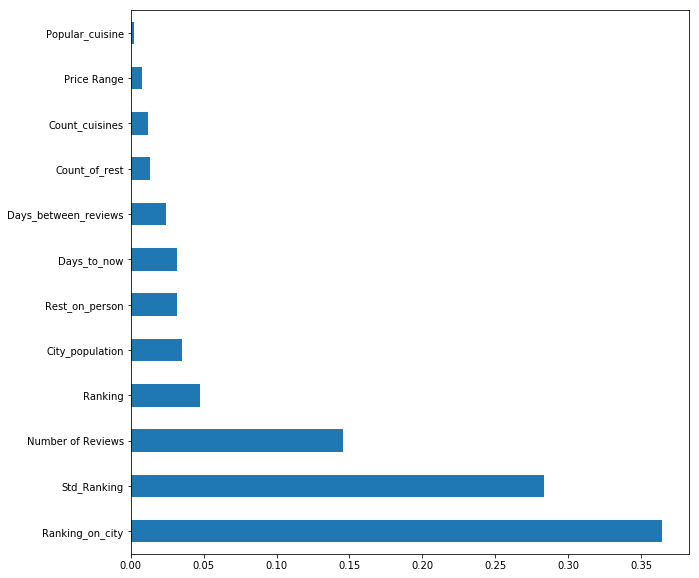

In [102]:
# In RandomForestRegressor it is possible to display the most important features for the model
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Preparing Submission for kaggle

In [103]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Popular_cuisine,Count_cuisines,Days_to_now,Days_between_reviews,Сity_population,Сount_of_rest,Rest_on_person,Ranking_on_city,Std_Ranking
689,724.0,2,5.0,0.0,1.0,1,1190.0,67.0,681,1137.0,0.598945,0.636763,0.522672
1948,4991.0,2,13.0,0.0,1.0,5,1072.0,67.0,1366,6275.0,0.217689,0.795378,1.047556
4776,4280.0,2,0.0,0.0,1.0,2,1072.0,67.0,1620,7796.0,0.207799,0.548999,0.176877
1124,1324.0,1,125.0,0.0,1.0,4,1043.0,155.0,1366,6275.0,0.217689,0.210996,-0.990345
3126,396.0,2,146.0,0.0,1.0,4,1257.0,108.0,769,1244.0,0.618167,0.318328,-0.615559
7480,2386.0,2,20.0,0.0,0.0,2,1123.0,143.0,506,3717.0,0.136131,0.641916,0.484438
9544,2756.0,0,0.0,0.0,1.0,1,1187.0,67.0,860,3254.0,0.264290,0.846958,1.239777
8002,837.0,2,3.0,0.0,1.0,1,1186.0,67.0,426,889.0,0.479190,0.941507,1.473107
1025,6130.0,2,30.0,0.0,1.0,4,1072.0,67.0,3223,8809.0,0.365876,0.695879,0.688972
5605,5949.0,0,0.0,0.0,1.0,1,1072.0,67.0,6010,6372.0,0.943189,0.933616,1.482767


In [104]:
test_data = test_data.drop(['Rating'], axis=1)

In [105]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [106]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [107]:
predict_submission

array([3.04 , 4.21 , 4.24 , ..., 3.055, 4.475, 4.265])

In [108]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.040
1,id_1,4.210
2,id_2,4.240
3,id_3,4.330
4,id_4,4.475
5,id_5,4.425
6,id_6,1.820
7,id_7,2.840
8,id_8,4.090
9,id_9,4.640
